# **CMPUT 690 Project - SemEval 2019 Task 4: Hyperpartisan News Detection**

Task: Given a news article text, decide whether it follows a hyperpartisan argumentation, i.e., whether it exhibits blind, prejudiced, or unreasoning allegiance to one party, faction, cause, or person.

Overview: https://pan.webis.de/semeval19/semeval19-web/index.html

##ML Approach 

Load modules

In [308]:
import os
import getopt
import sys
import xml.sax
import lxml.sax
import lxml.etree
import re
import json
import numpy
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import tree, preprocessing
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tag import StanfordNERTagger
import gensim
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from urllib.parse import urlparse
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import pandas as pd

In [309]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [310]:
ps = PorterStemmer()
stopWords = list(map(lambda x: ps.stem(x), stopwords.words('english')))
# websites = []

# with open('websites.txt') as f:
#     for website in f:
#         websites.append(website.strip().lower())


ARTICLE HANDLING

In [311]:
def handleArticle(article, model, X):
    text = lxml.etree.tostring(article, method='text', encoding='UTF-8').decode()
    htmltext = lxml.etree.tostring(article, method='html', encoding='UTF-8').decode()
    tokens = nltk.word_tokenize(text)

    finalArray = numpy.zeros(300)
    cnt = 0
    cnt2 = 0

    #for the model
    triggerWords = ['trigger', 'triggered', 'triggering', 'triggers', 'fuck', 'fucking', 'fuckery', 'fucked']
    triggerCount = 0

    #get word2vec representation for every word in article
    for token in tokens:
        if token in triggerWords:
            triggerCount += 1  
        if token in model and token not in stopWords:
            finalArray += model[token] 
            cnt += 1
        else:
            cnt2 += 1

    if cnt != 0:
        finalArray /= cnt

    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(text)

    websites = []

    with open('websites.txt') as f:
      for website in f:
        websites.append(website.strip().lower())

    #get core part of url, and check if it is in websites list
    websiteMatchCount = 0
    urls = re.findall(r'(?<=<a href=")[^"]*', htmltext)
    for url in urls:
        site = urlparse(url).netloc
        if site.startswith('www.'):
            site = site[4:]
        if site.lower() in websites:
            websiteMatchCount += 1

    #get date of article publification
    dateParts = str(article.get('published-at')).split('-')
    date = 0
    if len(dateParts) >= 2:
        year = int(str(article.get('published-at')).split('-')[0])
        month = int(str(article.get('published-at')).split('-')[1])
        date = year * 12 + month


    finalArray = numpy.append(finalArray, ss['neg'])
    finalArray = numpy.append(finalArray, ss['neu'])
    finalArray = numpy.append(finalArray, ss['pos'])
    finalArray = numpy.append(finalArray, ss['compound'])

    finalArray = numpy.append(finalArray, date)

    finalArray = numpy.append(finalArray, websiteMatchCount)

    finalArray = numpy.append(finalArray, triggerCount)

    #progress print
    print(article.get('id'), end='\r')
    
    X[article.get('id')] = list(finalArray)

SAX for stream parsing

In [312]:
class HyperpartisanArticleExtractor(xml.sax.ContentHandler):
    def __init__(self, model, X):
        xml.sax.ContentHandler.__init__(self)
        self.lxmlhandler = "undefined"
        self.model = model
        self.X = X

    def startElement(self, name, attrs):
        if name != "articles":
            if name == "article":
                self.lxmlhandler = lxml.sax.ElementTreeContentHandler()

            self.lxmlhandler.startElement(name, attrs)

    def characters(self, data):
        if self.lxmlhandler != "undefined":
            self.lxmlhandler.characters(data)

    def endElement(self, name):
        if self.lxmlhandler != "undefined":
            self.lxmlhandler.endElement(name)
            if name == "article":
                # pass to handleArticle function
                handleArticle(self.lxmlhandler.etree.getroot(), self.model, self.X)
                self.lxmlhandler = "undefined"        

class HyperpartisanTruthExtractor(xml.sax.ContentHandler):
    def __init__(self, X):
        xml.sax.ContentHandler.__init__(self)
        self.lxmlhandler = "undefined"
        self.X = X

    def startElement(self, name, attrs):
        if name != "articles":
            if name == "article":
                self.lxmlhandler = lxml.sax.ElementTreeContentHandler()

            self.lxmlhandler.startElement(name, attrs)

    def characters(self, data):
        if self.lxmlhandler != "undefined":
            self.lxmlhandler.characters(data)

    def endElement(self, name):
        if self.lxmlhandler != "undefined":
            self.lxmlhandler.endElement(name)
            if name == "article":
                self.X[self.lxmlhandler.etree.getroot().get("id")] = 1 if self.lxmlhandler.etree.getroot().get('hyperpartisan') == 'true' else 0
                self.lxmlhandler = "undefined"

def write(model, inputDataset, inputTruth, testDataset, testTruth, outputDataset, outputTruth, outputTestDataset, outputTestTruth):
    start_time = time.time()
    
    X1 = {}
    with open(inputDataset) as inputRunFile:
        print('parsing training dataset')
        xml.sax.parse(inputRunFile, HyperpartisanArticleExtractor(model, X1))
    json.dump(X1, open(outputDataset, 'w'))

    Y1 = {}
    with open(inputTruth) as inputTruthFile:
        print('parsing training truth')
        xml.sax.parse(inputTruthFile, HyperpartisanTruthExtractor(Y1))
    json.dump(Y1, open(outputTruth, 'w'))

    X2 = {}
    with open(testDataset) as testDatasetFile:
        print('parsing validation dataset')
        xml.sax.parse(testDatasetFile, HyperpartisanArticleExtractor(model, X2))
    json.dump(X2, open(outputTestDataset, 'w'))

    Y2 = {}
    with open(testTruth) as testTruthFile:
        print('parsing validation truth')
        xml.sax.parse(testTruthFile, HyperpartisanTruthExtractor(Y2))
    json.dump(Y2, open(outputTestTruth, 'w'))

    elapsed_time = time.time() - start_time
    
    print('FINISHED!', elapsed_time)
    return X1, Y1, X2, Y2

def read(trainingDataset, trainingTruth, validationDataset, validationTruth):
    start_time = time.time()
    # print('reading X1...')
    X1 = json.load(open(trainingDataset, 'r'))
    # print('reading Y1...')
    Y1 = json.load(open(trainingTruth, 'r'))
    # print('reading X2...')
    X2 = json.load(open(validationDataset, 'r'))
    # print('reading Y2...')
    Y2 = json.load(open(validationTruth, 'r'))

    print('done!', time.time() - start_time)
    
    return X1, Y1, X2, Y2         

def fitFunc(clf, X1, Y1, X2, Y2):
    start_time = time.time()
    
    X1 = list(X1.values())
    Y1 = list(Y1.values())
    X2 = list(X2.values())
    Y2 = list(Y2.values())

    # print('scaling dataset..')
    X1 = preprocessing.scale(X1)
    X2 = preprocessing.scale(X2)

    print('***********************')
    print('starting fit with:', clf)
    clf = clf.fit(X1, Y1)
    #dump the model
    pickle.dump(clf, open('model', 'wb'))

    #validate
    predicted = clf.predict(X2)
    print('accuracy_score', accuracy_score(predicted, Y2))

    print('time elapsed:', time.time() - start_time)
    print('***********************')

    return(accuracy_score(predicted, Y2))


For loading data from Google drive

In [313]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


Mounted at /content/gdrive
Mounted at /content/gdrive


Load model

In [314]:
# !pip install wget

# import wget
# url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# url = 'https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing'
# filename = wget.download(url)

In [315]:
#!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [316]:
#word2vec word embeddings
#The below step requires some time, downloads 1662.8 MB
# import gensim
# import gensim.downloader as api
# model = api.load("word2vec-google-news-300")
#Ref: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
#Ref: https://code.google.com/archive/p/word2vec/



In [317]:
import gzip
f_in = gzip.open( root_dir+'Colab Notebooks/BigData/GoogleNews-vectors-negative300.bin.gz', 'rb')
f_out = open(root_dir+'Colab Notebooks/BigData/GoogleNews-vectors-negative300.bin', 'wb')
f_out.writelines(f_in)

import gensim
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA

print('loading word2vec model...')
model = gensim.models.KeyedVectors.load_word2vec_format(root_dir+'Colab Notebooks/BigData/GoogleNews-vectors-negative300.bin', binary=True, limit=100000)

loading word2vec model...


GoogleNews-vectors-negative300.bin.gz is available at:

https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

Input and Output

In [318]:
# input dataset
inputDataset = root_dir+'Colab Notebooks/BigData/by-article/articles-training-byarticle-20181122.xml'
inputTruth = root_dir+'Colab Notebooks/BigData/by-article/ground-truth-training-byarticle-20181122.xml'
testDataset = root_dir+'Colab Notebooks/BigData/by-article/articles-test-byarticle-20181207.xml'
testTruth = root_dir+'Colab Notebooks/BigData/by-article/ground-truth-test-byarticle-20181207.xml'

#output files to which the parsed feature vectors will be output
s = "output"
st = "test-output"

outputDataset = s + '.txt'
outputTruth = s + '-truth.txt'
outputTestDataset = st  + '.txt'
outputTestTruth = st + '-truth.txt'


Input data is available at:
https://zenodo.org/record/5776081#.YljDSujMI2w

Parse the dataset and save the feature vectors to files

In [319]:
X1, Y1, X2, Y2 = write(model, inputDataset, inputTruth, testDataset, testTruth, outputDataset, outputTruth, outputTestDataset, outputTestTruth)
X1 = list(X1.values())
Y1 = list(Y1.values())
X2 = list(X2.values())
Y2 = list(Y2.values())

parsing training dataset
parsing training truth
parsing validation dataset
parsing validation truth
FINISHED! 37.170145750045776


Applying ML Classifiers for hyperpartisan news detection

In [320]:
#Store model results
model_results = {}
#Add baseline accuracy
model_results["BASELINE"] = 0.462

Logistic Regression

In [321]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(n_jobs=-1, verbose=1, random_state=42)
log_reg = log_reg.fit(X1, Y1)
predicted = log_reg.predict(X2)

log_reg_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["Logistic Regression"] = log_reg_acc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


accuracy_score 0.5


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


SVM

In [322]:
#Linear SVC
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(random_state=42)
#LinearSVC(random_state=0, tol=1e-05)
lin_svc = lin_svc.fit(X1, Y1)
predicted = lin_svc.predict(X2)

lin_svc_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["LinearSVC"] = lin_svc_acc


accuracy_score 0.5015923566878981


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [323]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [2**x for x in range(-5,5)]}] 
svc = GridSearchCV(SVC(gamma='auto'), parameters)

svc = svc.fit(X1, Y1)
predicted = svc.predict(X2)

svc_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["SVC"] = svc_acc


accuracy_score 0.5302547770700637


KNN

In [324]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X1, Y1)
predicted = knn.predict(X2)

knn_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["K-Nearest Neighbors"] = knn_acc

accuracy_score 0.5047770700636943


Decision Tree

In [325]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc = dtc.fit(X1, Y1)
predicted = dtc.predict(X2)

dtc_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["Decision Tree"] = dtc_acc

accuracy_score 0.47611464968152867


Random Forest

In [326]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1, random_state=42)
rfc = rfc.fit(X1, Y1)
predicted = rfc.predict(X2)

rfc_acc = accuracy_score(predicted, Y2)
print('accuracy_score', accuracy_score(predicted, Y2))

model_results["Random Forest"] = rfc_acc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s


accuracy_score 0.47929936305732485


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


Gradient Boosting

In [327]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# gbc = gbc.fit(X1, Y1)
# predicted = gbc.predict(X2)

# gbc_acc = accuracy_score(predicted, Y2)
# print('accuracy_score', accuracy_score(predicted, Y2))

# model_results["Gradient Boosting"] = gbc_acc

AdaBoost

In [328]:
# from sklearn.ensemble import AdaBoostClassifier
# abc = AdaBoostClassifier(n_estimators=100, random_state=0)
# abc = abc.fit(X1, Y1)
# predicted = abc.predict(X2)

# abc_acc = accuracy_score(predicted, Y2)
# print('accuracy_score', accuracy_score(predicted, Y2))

# model_results["AdaBoost"] = abc_acc

Model Results

In [329]:
import pandas as pd
model_results_df = pd.DataFrame(model_results.items(), columns=["Model","ACC"]).sort_values("ACC")
model_results_df

,Model,ACC
0,BASELINE,0.462000
5,Decision Tree,0.476115
6,Random Forest,0.479299
1,Logistic Regression,0.500000
2,LinearSVC,0.501592
4,K-Nearest Neighbors,0.504777
3,SVC,0.530255


Visualization

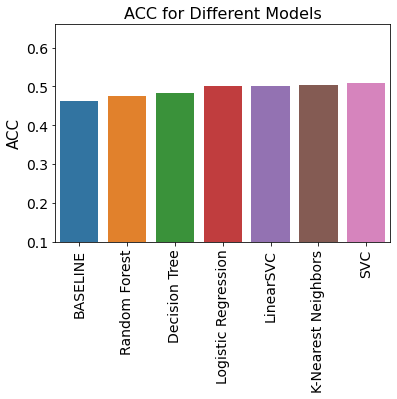

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.barplot(x="Model", y="ACC", data=model_results_df)
plt.setp(ax.get_xticklabels(), rotation=90);
plt.ylim(.1,.66);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('');
ax.set_ylabel('ACC', fontsize=15);
ax.set_title("ACC for Different Models", fontsize=16);

Acknowledgement: https://github.com/ilovrencic/SemEval2019-Hyperpartisan-News-Detection

TODO: Hyperparameter Tuning

##DL Approach 

In [246]:
!pip install bleach

In [247]:
!pip install beautifulsoup4

In [248]:
!pip install datasets

In [249]:
!pip install transformers==4.2.1

In [250]:
!pip install pytorch-lightning

In [251]:
!pip install typing-extensions==4.0.0

In [252]:
!pip install tf-estimator-nightly==2.8.0.dev2021122109

In [253]:
!pip install folium==0.2.1

In [254]:
import datasets
from datasets import list_datasets, load_dataset, list_metrics, load_metric
datasets_list = list_datasets()
import torch
import re
import bleach
from bs4 import BeautifulSoup

In [255]:
dataset  = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')

Reusing dataset hyperpartisan_news_detection (/root/.cache/huggingface/datasets/hyperpartisan_news_detection/bypublisher/1.0.0/7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

In [256]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
    validation: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
})


Details of the by-publisher dataset

In [257]:
print("Size of train dataset: ", dataset['train'].shape)

Size of train dataset:  (600000, 6)


In [258]:
dataset['train']

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
    num_rows: 600000
})

In [259]:
position = 1

In [260]:
print(" Example of title: ", dataset['train'][position]['title'])
print(" Example of text: ", dataset['train'][position]['text'])
print(" Example of url: ", dataset['train'][position]['url'])
print(" Length of text: ", len(dataset['train'][position]['text'].split(" ")))

 Example of title:  University To Award Trayvon Martin With Posthumous Degree In Aviation
 Example of text:  <p>A Florida university will honor Trayvon Martin with a posthumous Bachelor of Science Degree in Aviation at a May 13 commencement ceremony. The degree will be accepted by his parents, Tracy Martin and Sabrina Fulton.</p> 

<p>Seventeen-year-old Martin was killed in February of 2012 by former neighborhood watch captain George Zimmerman, who is Hispanic, in self-defense. After a long, racially-charged public debate and court trial, Zimmerman was completely exonerated in July of 2013.</p> 

<p>Florida Memorial University officially <a href="https://www.facebook.com/FLMemorialUniv/" type="external">announced</a>the posthumous degree via Facebook on Wednesday.</p> 

<p>"The University will confer upon TRAYVON MARTIN a posthumous degree in Aeronautical Science with a concentration in Flight Education, in honor of the steps he took during his young life toward becoming a pilot," says

In [261]:
print(" Class of above text: ",  dataset['train'][position]['hyperpartisan'])

 Class of above text:  True


Data Preprocessing

In [262]:
def clean_text(text, label):
    """ Clean the input text and remove special characters """
#     soup = BeautifulSoup(text)
    text = bleach.clean(text,strip=True)
    text = text.replace('<p>', '')
    text = text.replace('</p>', '')
    text = text.replace('\n', '')
    text = text.replace('&amp;#160;', '')
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    if str(label) == 'True':
        new_label = 1
    else:
        new_label = 0
    return text, new_label


def convert_to_features(example):
    # Tokenize contexts and questions (as pairs of inputs)
    text_, target_ = clean_text(example['text'], example['hyperpartisan'])
    encodings = tokenizer.encode_plus(text_, pad_to_max_length=True, max_length=2048,
                                           add_special_tokens=True,
                                            return_token_type_ids=False,
                                            return_attention_mask=True,
                                            padding='max_length', truncation=True,
                                            
                                           )
    targets = torch.tensor(target_,dtype=torch.long)
    print(targets)

    encodings.update({'targets': targets,
                      'attention_mask': encodings['attention_mask']})
    print(encodings)
    return encodings

In [263]:
from transformers import LongformerTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Remaining tasks: Longformer finetuning and evaluation

TODO: We have tried several approches using BERT or Longformer for the DL approach, main issue lies in formatting the input properly for the models, which will be further investigated. We expect Longformer or Big Bird to perform extremely well for this task as they are able to handle much longer sequences of text compared to BERT.

Resources found:

1) Towards data science: https://towardsdatascience.com/train-a-longformer-for-detecting-hyperpartisan-news-content-7c141230784e

2) Github: https://github.com/priya-dwivedi/Deep-Learning/blob/master/Longformer_HyperPartisan_news/Longformer_classifier_HyperPartisan_News.ipynb

3) Longformer: https://github.com/allenai/longformer

4) Longformer example: https://jesusleal.io/2020/11/24/Longformer-with-IMDB/

Websites:

1) Medium: https://jjpryor.medium.com/how-statistically-biased-is-our-news-f28f0fab3cb3

2) Medium: https://medium.com/politically-speaking/dont-trust-these-news-sources-read-these-instead-8c4995f3cf87

3) Business Insider: https://www.businessinsider.com/most-and-least-biased-news-outlets-in-america-2018-6